<a href="https://colab.research.google.com/github/krooner/data-analysis-projects/blob/main/04_classification_cv_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교차검증과 앙상블 모델을 활용한 와인 품질 분류하기
---

## 1. Import libraries

In [40]:
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.decomposition import PCA

%matplotlib inline

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=67b039f43bba083026d146c5f919922dc5ee655f42f3a483de25d5f2b20c8fa8
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


## 2. Download dataset

In [7]:
!wget 'https://bit.ly/3i4n1QB'

import zipfile
with zipfile.ZipFile('3i4n1QB', 'r') as existing_zip:
    existing_zip.extractall('data')

--2022-05-22 06:59:24--  https://bit.ly/3i4n1QB
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw [following]
--2022-05-22 06:59:24--  https://drive.google.com/uc?export=download&id=1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw
Resolving drive.google.com (drive.google.com)... 74.125.141.102, 74.125.141.113, 74.125.141.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/frirrlcvchq4263i838hugcaa7d053vj/1653202725000/17946651057176172524/*/1emLrrpFWT8dCoj5BJb12-5QMG2-nruUw?e=download [following]
--2022-05-22 06:59:24--  https://doc-10-10-docs.googleusercontent.com/docs/securesc/ha0ro937

## 3. Load file

In [9]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train.drop(['index'], axis = 1, inplace = True)
test.drop(['index'], axis = 1, inplace = True)

train = pd.get_dummies(train)
test = pd.get_dummies(test)

## 4. EDA

### `train`
피쳐 종류는 다음과 같다.


||index|quality|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|totla sulfur dioxide|density|pH|sulphates|alcohol|type|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---| 
||구분자|품질|산도|휘발성산|시트르산|잔당|염화물|독립 이산화황|총 이산화황|밀도|수소이온농도|황산염|도수|종류|

`quality`는 종속 변수로, 3부터 9까지의 정수

`type`을 제외한 컬럼이 모두 수치형 데이터이다. 
- **수치형 데이터 간의 상관관계** 분석을 통해 필요없는 피쳐는 제외한다.

`type`과 같은 카테고리 변수는 One-hot Vector 변환

In [ ]:
print(train.info())
print()
# print(train.isnull().sum())
# print()
print(train.describe())
print()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5497 entries, 0 to 5496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5497 non-null   int64  
 1   quality               5497 non-null   int64  
 2   fixed acidity         5497 non-null   float64
 3   volatile acidity      5497 non-null   float64
 4   citric acid           5497 non-null   float64
 5   residual sugar        5497 non-null   float64
 6   chlorides             5497 non-null   float64
 7   free sulfur dioxide   5497 non-null   float64
 8   total sulfur dioxide  5497 non-null   float64
 9   density               5497 non-null   float64
 10  pH                    5497 non-null   float64
 11  sulphates             5497 non-null   float64
 12  alcohol               5497 non-null   float64
 13  type                  5497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 601.4+ KB
None

      

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


### 시각화
`pairplot`

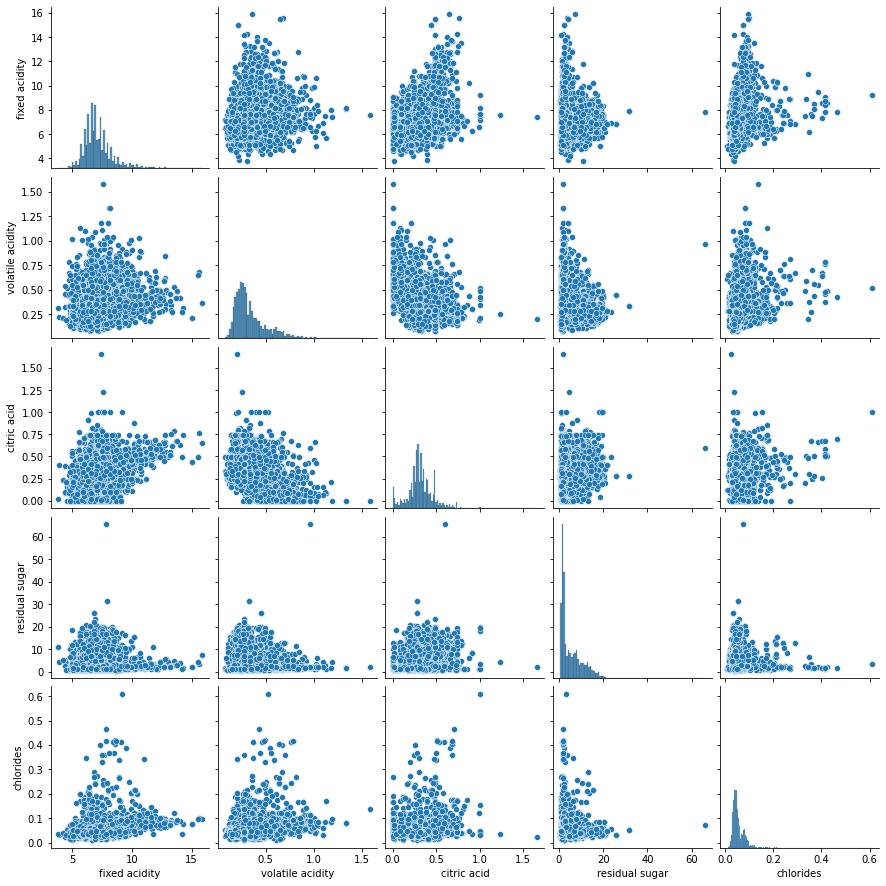

In [15]:
data = train.loc[:, 'fixed acidity':'chlorides']
sns.pairplot(data)

`distplot`

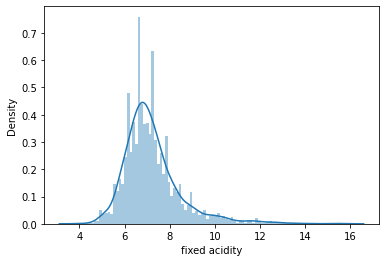

In [17]:
data = train['fixed acidity']
sns.distplot(data, bins = 100)

`heatmap`

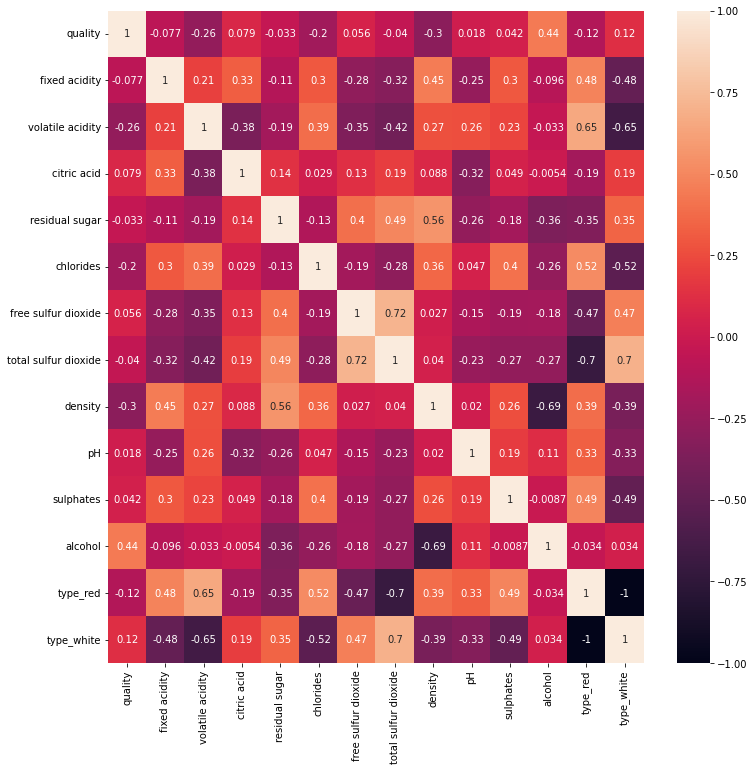

In [18]:
data = train.corr()
plt.figure(figsize = (12, 12))
sns.heatmap(train.corr(), annot = True)

`scatterplot`

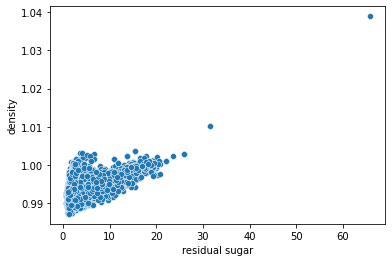

In [19]:
x_data, y_data = train['residual sugar'], train['density']
sns.scatterplot(x_data, y_data)

### `test`
피쳐 종류는 `quality`를 제외하고 동일

In [16]:
print(test.info())
print()
# print(test.isnull().sum())
# print()
print(test.describe())
print()
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1000 non-null   float64
 1   volatile acidity      1000 non-null   float64
 2   citric acid           1000 non-null   float64
 3   residual sugar        1000 non-null   float64
 4   chlorides             1000 non-null   float64
 5   free sulfur dioxide   1000 non-null   float64
 6   total sulfur dioxide  1000 non-null   float64
 7   density               1000 non-null   float64
 8   pH                    1000 non-null   float64
 9   sulphates             1000 non-null   float64
 10  alcohol               1000 non-null   float64
 11  type_red              1000 non-null   uint8  
 12  type_white            1000 non-null   uint8  
dtypes: float64(11), uint8(2)
memory usage: 88.0 KB
None

       fixed acidity  volatile acidity  citric acid  residual sugar  \


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,9.0,0.31,0.48,6.6,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,0,1
1,13.3,0.43,0.58,1.9,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,1,0
2,6.5,0.28,0.27,5.2,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,0,1
3,7.2,0.15,0.39,1.8,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,0,1
4,6.8,0.26,0.26,2.0,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,0,1


## 5. 전처리
`Multicollinearity` 다중공선성

상관관계가 높은 변수들이 존재한다는 것은 곧 사실상 동일한 값들이 중복적으로 데이터로 활용된다. 이러한 경우 모델 성능을 하락시킬 수 있다.
1. `heatmap`으로 확인하기
2. `scatterplot`으로 확인하기
3. **`VIF (Variance Inflation Factors)`로 확인하기**

In [22]:
vif_df = pd.DataFrame()
vif_df['VIF'] = [round(vif(train.values, i), 2) for i in range(train.shape[1])]
vif_df['Features'] = train.columns
vif_df

,VIF,Features
0,1.42,quality
1,4.86,fixed acidity
2,2.28,volatile acidity
3,1.61,citric acid
4,9.56,residual sugar
5,1.68,chlorides
6,2.22,free sulfur dioxide
7,4.05,total sulfur dioxide
8,21.79,density
9,2.50,pH


#### 데이터 정규화 (Normalization) 후 VIF 확인

In [23]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scale = scaler.transform(train)
train_scale = pd.DataFrame(train_scale)

vif_df = pd.DataFrame()
vif_df['VIF'] = [round(vif(train_scale.values, i), 2) for i in range(train_scale.shape[1])]
vif_df['Features'] = train.columns
vif_df

,VIF,Features
0,1.42,quality
1,4.86,fixed acidity
2,2.28,volatile acidity
3,1.61,citric acid
4,9.56,residual sugar
5,1.68,chlorides
6,2.22,free sulfur dioxide
7,4.05,total sulfur dioxide
8,21.79,density
9,2.50,pH


#### Continuous Value를 카테고리 값으로 바꾸기

In [27]:
train['alcohol'] = pd.cut(train.alcohol, 5, labels=False)
test['alcohol'] = pd.cut(test.alcohol, 5, labels=False)

train['alcohol'].describe()

count    5497.000000
mean        1.340731
std         0.924242
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: alcohol, dtype: float64

#### Polynomial Features

In [94]:
poly_features = PolynomialFeatures(degree = 2)
X_train = train.drop(['quality'], axis = 1)
Y_train = train['quality']
train_poly = poly_features.fit_transform(X_train)
train_poly = pd.DataFrame(train_poly)

test_poly = poly_features.fit_transform(test)
test_poly = pd.DataFrame(test_poly)

## 6. 하이퍼파라미터 튜닝
Bayesian Optimization


**For `RandomForestClassifier`**





In [95]:
rf_params = {
    'max_depth': (1, 13),
    'n_estimators': (30, 500)
}

def bayes_function_rf(max_depth, n_estimators):
  param = {
      'max_depth': int(round(max_depth)),
      'n_estimators': int(round(n_estimators))
  }

  model = RandomForestClassifier(**param)

  # X_train_bo, X_valid_bo, Y_train_bo, Y_valid_bo = train_test_split(X_train, Y_train, test_size = .2)
  X_train_bo, X_valid_bo, Y_train_bo, Y_valid_bo = train_test_split(train_poly, Y_train, test_size = .2)

  model.fit(X_train_bo, Y_train_bo)

  score = accuracy_score(Y_valid_bo, model.predict(X_valid_bo))

  return score

In [96]:
bayes_rf = BayesianOptimization(
    f = bayes_function_rf, 
    pbounds = rf_params,
    random_state = 42)

bayes_rf.maximize(init_points = 5, n_iter = 5)

max_params_r = bayes_rf.max['params']
max_params_r['max_depth'] = int(max_params_r['max_depth'])
max_params_r['n_estimators'] = int(max_params_r['n_estimators'])
max_params_r

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.5509   |  5.494    |  476.8    |
|  2        |  0.6191   |  9.784    |  311.4    |
|  3        |  0.5645   |  2.872    |  103.3    |
|  4        |  0.5427   |  1.697    |  437.1    |
|  5        |  0.6109   |  8.213    |  362.8    |
|  6        |  0.51     |  1.0      |  241.1    |
|  7        |  0.6064   |  9.182    |  312.3    |
|  8        |  0.6827   |  12.5     |  306.9    |
|  9        |  0.6682   |  13.0     |  299.6    |
|  10       |  0.5264   |  3.678    |  301.0    |


{'max_depth': 12, 'n_estimators': 306}

**For `XGBoost`**

In [97]:
xgb_params = {
    'gamma': (0, 10),
    'max_depth': (1, 13),
    'subsample': (.5, 1)
}

def bayes_function_xgb(gamma, max_depth, subsample):
  param = {
      'gamma': int(round(gamma)),
      'max_depth': int(round(max_depth)),
      'subsample': int(round(subsample))
  }

  model = XGBClassifier(**param)

  # X_train_bo, X_valid_bo, Y_train_bo, Y_valid_bo = train_test_split(X_train, Y_train, test_size = .2)
  X_train_bo, X_valid_bo, Y_train_bo, Y_valid_bo = train_test_split(train_poly, Y_train, test_size = .2)

  model.fit(X_train_bo, Y_train_bo)

  score = accuracy_score(Y_valid_bo, model.predict(X_valid_bo))

  return score

In [98]:
bayes_xgb = BayesianOptimization(
    f = bayes_function_xgb, 
    pbounds = xgb_params,
    random_state = 42)

bayes_xgb.maximize(init_points = 5, n_iter = 5)

max_params_x = bayes_xgb.max['params']
max_params_x['max_depth'] = int(max_params_x['max_depth'])
max_params_x['gamma'] = int(max_params_x['gamma'])
max_params_x['subsample'] = max_params_x['subsample']
max_params_x

|   iter    |  target   |   gamma   | max_depth | subsample |
-------------------------------------------------------------
|  1        |  0.6491   |  3.745    |  12.41    |  0.866    |
|  2        |  0.5982   |  5.987    |  2.872    |  0.578    |
|  3        |  0.6682   |  0.5808   |  11.39    |  0.8006   |
|  4        |  0.5482   |  7.081    |  1.247    |  0.985    |
|  5        |  0.5655   |  8.324    |  3.548    |  0.5909   |
|  6        |  0.003636 |  1.797    |  7.479    |  0.5      |
|  7        |  0.5882   |  7.047    |  13.0     |  1.0      |
|  8        |  0.6727   |  1.454    |  12.98    |  0.5137   |
|  9        |  0.5773   |  10.0     |  8.989    |  1.0      |
|  10       |  0.5673   |  0.0      |  1.0      |  1.0      |


{'gamma': 1.4535555327494898, 'max_depth': 12, 'subsample': 0.5136788983018713}

**For `LGBM`**



In [100]:
lgbm_params = {
    'n_estimators': (30, 500),
    'max_depth': (1, 13),
    # 'subsample': (.5, 1)
}

def bayes_function_lgbm(n_estimators, max_depth):#, subsample):
  param = {
      'n_estimators': int(round(n_estimators)),
      'max_depth': int(round(max_depth)),
      # 'subsample': int(round(subsample))
  }

  model = LGBMClassifier(**param)

  # X_train_bo, X_valid_bo, Y_train_bo, Y_valid_bo = train_test_split(X_train, Y_train, test_size = .2)
  X_train_bo, X_valid_bo, Y_train_bo, Y_valid_bo = train_test_split(train_poly, Y_train, test_size = .2)

  model.fit(X_train_bo, Y_train_bo)

  score = accuracy_score(Y_valid_bo, model.predict(X_valid_bo))

  return score

In [101]:
bayes_lgbm = BayesianOptimization(
    f = bayes_function_lgbm,
    pbounds = lgbm_params,
    random_state = 42)

bayes_lgbm.maximize(init_points = 5, n_iter = 5)

max_params_l = bayes_lgbm.max['params']
max_params_l['max_depth'] = int(max_params_l['max_depth'])
max_params_l['n_estimators'] = int(max_params_l['n_estimators'])
# max_params_l['subsample'] = max_params_l['subsample']
max_params_l

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.6482   |  5.494    |  476.8    |
|  2        |  0.6564   |  9.784    |  311.4    |
|  3        |  0.5727   |  2.872    |  103.3    |
|  4        |  0.6245   |  1.697    |  437.1    |
|  5        |  0.6455   |  8.213    |  362.8    |
|  6        |  0.69     |  11.17    |  311.5    |
|  7        |  0.6573   |  12.64    |  310.7    |
|  8        |  0.6482   |  11.81    |  312.6    |
|  9        |  0.6764   |  10.76    |  310.2    |
|  10       |  0.6636   |  11.74    |  308.2    |


{'max_depth': 11, 'n_estimators': 311}

## 7. Voting Classifier

In [104]:
LGBM = LGBMClassifier(**max_params_l)
XGB = XGBClassifier(**max_params_x)
RF = RandomForestClassifier(**max_params_r)

# VotingClassifier 정의
VC = VotingClassifier(
    estimators = [('rf', RF), ('xgb', XGB), ('lgbm', LGBM)], 
    voting = 'soft')

VC.fit(train_poly, Y_train)
# pred = VC.predict(test)
pred = VC.predict(test_poly)

## 8. 결과 저장

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['quality'] = pred
submission.to_csv('tuned_vote_poly.csv',index=False)